# Cálculo da Fronteira Eficiente e Simulação de Carteiras

In [1]:
# Bibliotecas
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
import scipy.optimize as solver

In [2]:
# Ler e tratar as bases
def read_infoMoney(file_name):
    df = pd.read_csv('Bases/'+ file_name, sep=',', thousands='.', decimal=',')
    df.index = df['DATA']
    df = df['FECHAMENTO']
    return df

In [3]:
# Dicionário de ativos
assets = {'ABEV3': 'Ambev SA ABEV3',
          'PETR3': 'Petrobras PETR3',
          'MGLU3': 'Magazine Luiza MGLU3',
          'ITUB3': 'Itaú Unibanco ITUB3',
          'ALPA3': 'Alpargatas ALPA3',
          'VALE3': 'Vale S.A. VALE3'}

In [4]:
# Consolidando os dados em um único DF
df_assets = pd.DataFrame()

for ativo in assets.keys():
    df_assets[ativo] = read_infoMoney(assets[ativo])
    
df_assets

,ABEV3,PETR3,MGLU3,ITUB3,ALPA3,VALE3
DATA,,,,,,
28/12/2018,13.99,20.27,5.59,20.52,20.17,40.76
27/12/2018,13.73,19.51,5.38,20.14,19.66,39.56
26/12/2018,13.77,19.62,5.46,19.81,NaN,40.31
21/12/2018,13.80,19.26,5.65,20.01,20.69,40.65
20/12/2018,13.83,19.24,5.50,20.35,20.03,39.81
...,...,...,...,...,...,...
08/01/2018,19.08,14.32,2.42,17.01,20.43,33.20
05/01/2018,19.11,14.10,2.42,17.11,20.38,32.48
04/01/2018,19.04,13.99,2.47,16.99,20.48,31.98


In [5]:
# Calcular retornos
def calc_return(df, hp):
    df_returns = df/df.shift(-hp) - 1 # Faz o shit com -hp pois as datas estão ordenadas da mais recente para a mais antiga
    df_returns.dropna(inplace=True)   # Remove registros com valores faltantes
    return df_returns

retornos = calc_return(df_assets, 1)

In [6]:
# Cálculo da correlação entre os ativos
correl_matrix = retornos.corr() #Correlação
cov_matrix = retornos.cov() #Covariância

In [7]:
# Cálculo do retorno e desvio padrão dos ativos
# Multiplica por 252 para anualizar o risco e retorno

mi =  retornos.mean()*252 # média
sigma = retornos*252**(1/2) # desvio padrão
sigma = sigma.std()
rr_ativos = pd.DataFrame({'retorno':mi, 'risco':sigma})

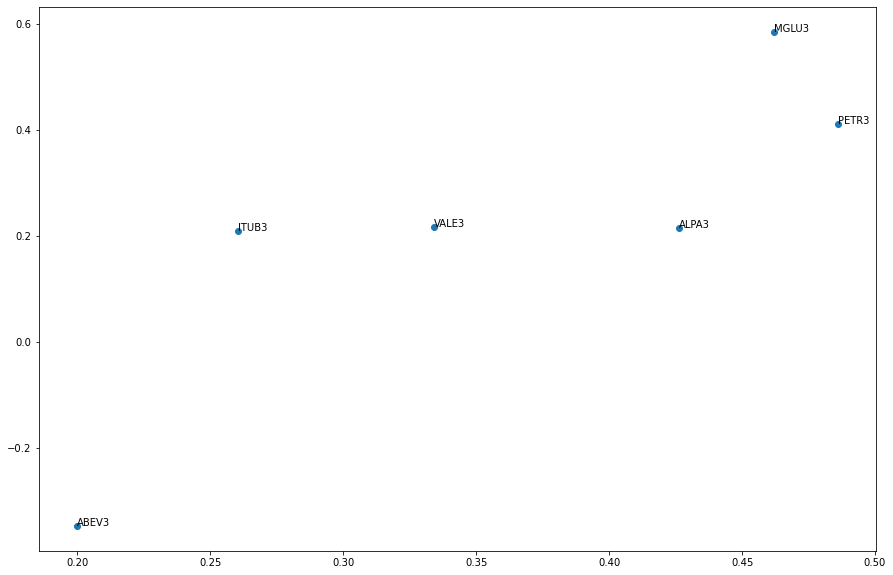

In [8]:
# Gráfico dos ativos: retorno x risco

plt.figure(figsize=[15,10])
plt.scatter(x=rr_ativos['risco'], y=rr_ativos['retorno'])
for i in range(len(rr_ativos.index)):
    plt.annotate(rr_ativos.index[i],(rr_ativos['risco'][i], rr_ativos['retorno'][i]))

In [9]:
# Compondo uma carteira 
carteira1 = rr_ativos.copy()
carteira1['peso'] = [0.05, 0.05, 0.12, 0.48, 0.1, 0.2]
carteira1

,retorno,risco,peso
ABEV3,-0.347743,0.199718,0.05
PETR3,0.410540,0.485905,0.05
MGLU3,0.585161,0.462024,0.12
ITUB3,0.210197,0.260469,0.48
ALPA3,0.214737,0.426382,0.10
VALE3,0.217365,0.334239,0.20


In [10]:
# Cálculo de retorno e risco da carteira
mi_P = (carteira1['retorno'] * carteira1['peso']).sum()
sigma_P = (np.dot(np.dot(carteira1['peso'], cov_matrix*252), carteira1['peso']))**(1/2)

print(f'Retorno esperado: {round(mi_P*100, 4)}%, risco: {round(sigma_P*100, 4)}%')

Retorno esperado: 23.92%, risco: 21.4187%


**O código abaixo utiliza uma função aleatória para criar os pesos das carteiras, portanto serão carteiras diferentes a  cada execução**

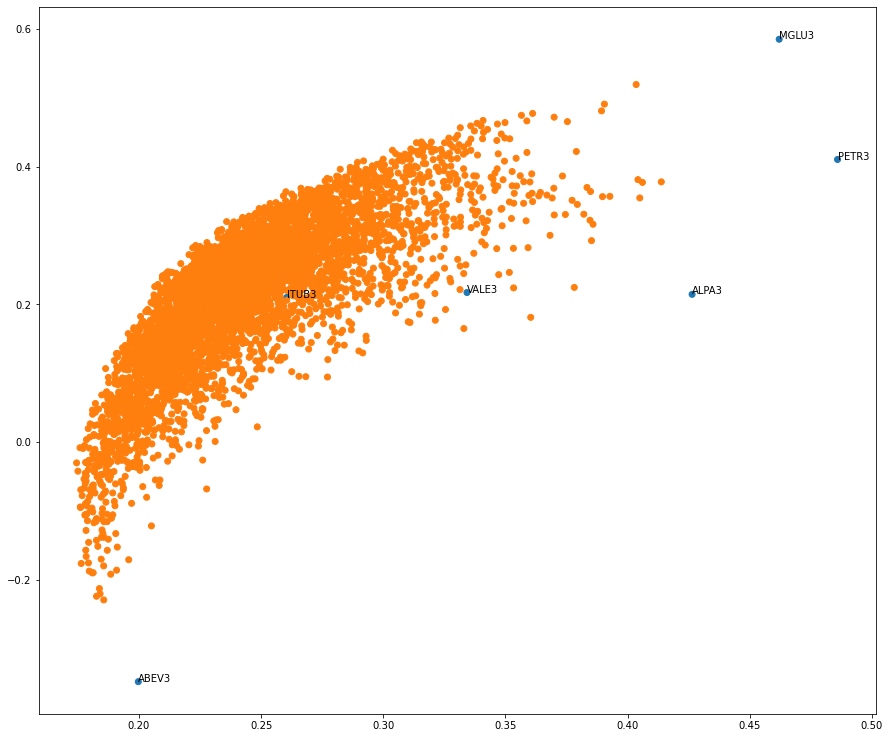

In [11]:
# Simulando carteiras com pesos diferentes
quant_carteiras = 5000
# Criação dos pesos das carteiras
carteiras = []

# DataFrame de retorno e risco
rr_carteiras = rr_ativos.copy()
rr_carteiras['tipo'] = 'ativo'  #Dataframe das carteiras onde os primeiros registros são os ativos

for i in range(quant_carteiras):
    #Adiciona uma nova carteira na lista de carteiras
    carteiras.append(pd.DataFrame({'peso': np.random.dirichlet(np.ones(len(rr_ativos)), size=1).reshape(-1)},index=rr_ativos.index))
    
    #Adiciona o risco e retorno no dataframe de carteiras
    rr_carteiras.loc['Carteira '+str(i),'retorno'] = (carteira1['retorno'] * carteiras[i]['peso']).sum()
    rr_carteiras.loc['Carteira '+str(i),'risco'] = (np.dot(np.dot(carteiras[i]['peso'], cov_matrix*252),carteiras[i]['peso']))**(1 / 2)
    rr_carteiras.loc['Carteira '+str(i),'tipo'] = 'carteira' 

# Gráfico
cores = {'ativo':'tab:blue', 'carteira':'tab:orange'}
plt.figure(figsize=[15,13])
plt.scatter(x=rr_carteiras['risco'], y=rr_carteiras['retorno'], c=rr_carteiras['tipo'].map(cores))
for i in range(6):
    plt.annotate(rr_carteiras.index[i],(rr_carteiras['risco'][i], rr_carteiras['retorno'][i]))

## Otimização de portfólio

Todo processo de otimização necessita da elaboração de uma função objetiva e da definição de um conjunto de restrições (se houver). Por exemplo, podemos minimizar uma função custo ou maximizar uma função de lucro. No nosso caso, utilizando a teoria de portfólio de Markowitz, desejamos uma das duas coisas:
- minimizar a volatilidade da carteira ou
- maximizar os retornos esperados

Analisaremos adiante cada um dos casos.

### Minimizar a volatilidade

Neste caso, desejamos obter um conjunto de pesos para os ativos da análise, tais que o risco da carteira ponderada por estes pesos seja o menor possível. Podemos escrever este objetivo da seguinte forma:

$$ min F(w) = \sqrt{\sum_{i=1}^N \sum_{j=1}^N W_i \cdot W_j \cdot COV_{i,j}} $$

Contudo, devemos considerar nossas restrições. A primeira delas refere-se aos valores dos pesos. Por definição, estes devem sempre somar 1. Portanto:

$$\sum_{i=1}^N W_i = 1 $$

ou

$$\sum_{i=1}^N W_i - 1 = 0 $$

A segunda restrição refere-se ao retorno desejado para a carteira, $\mu$. Para que este objetivo seja alcançado, podemos definir:

$$\sum_{i=1}^N W_i r_i = \mu $$

ou

$$\sum_{i=1}^N W_i r_i - \mu = 0 $$

Por fim, precisamos que os pesos possuam valores positivos e sejam menores que 100\%:

$$ w_i >= 0, \forall i=1,...,n $$
$$ w_i <= 1, \forall i=1,...,n $$

O que o cálculo numérico realiza é uma busca para encontrar o melhor conjunto de pesos para cada ativo que garanta que as restrições são respeitadas e que se tenha o menor risco possível.

---

Biblioteca Python utilizada para otimização:

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

---


In [12]:
# Definindo função objetivo
def f_obj_min_risk(w):
    return np.sqrt(np.dot(w, np.dot(cov_matrix*252, w)))

# Definindo valor inicial
w_ini = np.array([1/len(mi)]* len(mi)) 

In [13]:
# Definindo o retorno desejado
ret = 0.3

# Definindo restrições
constraints = [{'type': 'eq', 'fun': lambda x: sum(x) - 1}, # primeira restrição
               {'type': 'eq', 'fun': lambda x: sum(x*mi) - ret}] # segunda restrição

# Definindo limites para os pesos
bounds = tuple((0, 1) for x in range(len(mi))) 

result = solver.minimize(f_obj_min_risk, w_ini, constraints=constraints, bounds=bounds, 
                         method='SLSQP')
result

In [15]:
print(f'Risco portfólio (%): {round(result.fun*100,2)}')
peso_otimo = pd.DataFrame({'peso ótimo (%)':[round(w*100, 2) for w in result.x]}, index=rr_ativos.index )
peso_otimo

Risco portfólio (%): 22.5


,peso ótimo (%)
ABEV3,0.00
PETR3,3.14
MGLU3,21.56
ITUB3,31.41
ALPA3,17.89
VALE3,26.00


In [16]:
# Simulando para diversos retornos (buscando a fronteira eficiente)
ret_range = np.arange(-0.4, 0.7, 0.001)
sigma_sim = []

for ret in ret_range:
    constraints = [{'type': 'eq', 'fun': lambda x: sum(x) - 1}, # primeira restrição
                   {'type': 'eq', 'fun': lambda x: sum(x*mi) - ret}] # segunda restrição
    
    result = solver.minimize(f_obj_min_risk, w_ini, constraints=constraints, bounds=bounds, 
                         method='SLSQP')
    sigma_sim.append(result.fun)

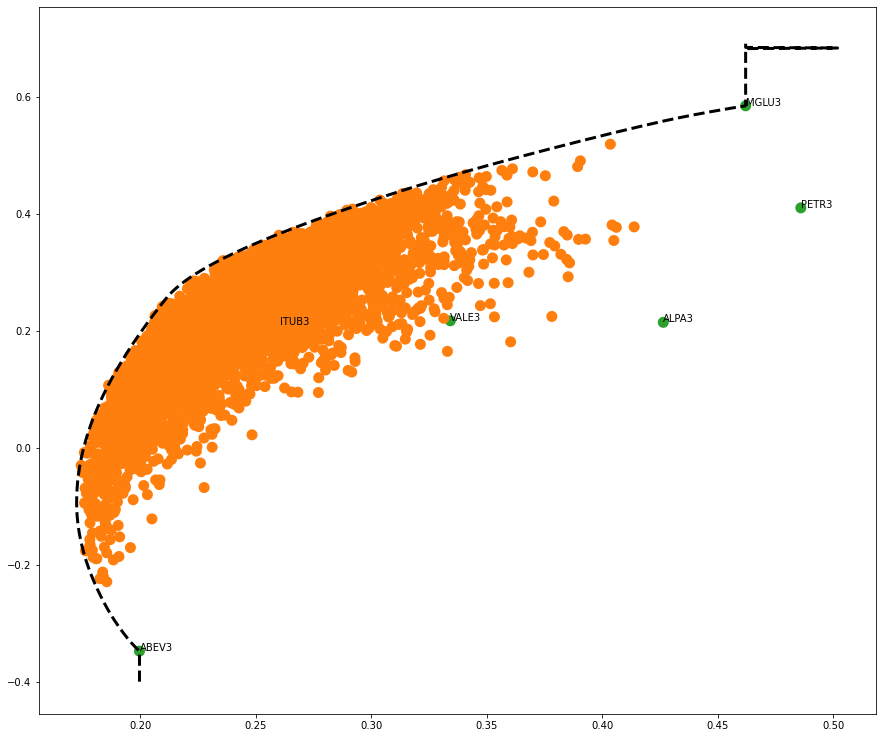

In [17]:
plt.figure(figsize=[15,13])
#Fronteira eficiente
plt.plot(sigma_sim, ret_range, 'k--', linewidth=3, )

#Carteiras simuladas
cores = {'ativo':'tab:green', 'carteira':'tab:orange'}
plt.scatter(x=rr_carteiras['risco'], y=rr_carteiras['retorno'], c=rr_carteiras['tipo'].map(cores), linewidths=5)
for i in range(6):
    plt.annotate(rr_carteiras.index[i],(rr_carteiras['risco'][i], rr_carteiras['retorno'][i]))

**O otimizador não consegue achar solução que atenda a restrição de retorno desejado menor que o retorno do ativo com menor retorno e nem retorno desejado maior que o retorno do ativo com maior retorno. Isso acontece porque existe a restrição que o somatório dos pesos dos ativos deve ser igual a 1, e também a restrição que os pesos dos ativos devem estar entre 0 e 1. Portanto não haverão carteiras onde o retorno seja maior que o da MGLU3 ou menor que o da ABEV3**

### Maximizar o retorno
Neste caso, fixamos a volatilidade desejada $\sigma_P$ e definimos a função objetivo para ampliar os retornos calculados a partir dos pesos. O problema de otimização pode ser rezumido por:

$$ max F(w) = \sum_{i=1}^N W_i r_i $$

Sujeito a:

$$\sqrt{\sum_{i=1}^N \sum_{j=1}^N W_i \cdot W_j \cdot COV_{i,j}} = \sigma_P $$
$$\sum_{i=1}^N W_i - 1 = 0 $$
$$ w_i >= 0, \forall i=1,...,n $$
$$ w_i <= 1, \forall i=1,...,n $$

Nas bibliotecas existentes, os problemas de otimização sempre são descritas como minimização. Mas isto não é um problema, pois podemos simplesmente inverter o sinal da função objetivo:

$$ min F(w) = - \sum_{i=1}^N W_i r_i $$

In [18]:
# Definindo função objetivo

def f_obj_max_ret(w):
    return -(w*mi).sum()

# Definindo valor inicial
w_ini = np.array([1/len(mi)]* len(mi)) 


# Definindo o risco desejado
risco = 0.3

# Definindo restrições
constraints = [{'type': 'eq', 'fun': lambda x: sum(x) - 1}, # primeira restrição
               {'type': 'eq', 'fun': lambda x: np.sqrt(np.dot(x, np.dot(cov_matrix*252, x))) - risco}] # segunda restrição


# Definindo limites para os pesos
bounds = tuple((0, 1) for x in range(len(mi))) 

In [19]:
# Imprime resultado
result = solver.minimize(f_obj_max_ret, w_ini, constraints=constraints, bounds=bounds, 
                         method='SLSQP')
result

     fun: -0.42288394864073114
     jac: array([ 0.34774299, -0.41054039, -0.58516102, -0.21019653, -0.21473688,
       -0.21736466])
 message: 'Optimization terminated successfully'
    nfev: 63
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([0.        , 0.12898007, 0.49270857, 0.026498  , 0.16097531,
       0.19083806])

In [20]:
# Simulando para diversos riscos (buscando a fronteira eficiente)
risco_range = np.arange(0.15, 0.5, 0.001)
retorno_sim = []

for risco in risco_range:
    constraints = [{'type': 'eq', 'fun': lambda x: sum(x) - 1}, # primeira restrição
                   {'type': 'eq', 'fun': lambda x: np.sqrt(np.dot(x, np.dot(cov_matrix*252, x))) - risco}] # segunda restrição
    
    result = solver.minimize(f_obj_max_ret, w_ini, constraints=constraints, bounds=bounds, 
                         method='SLSQP', options={'maxiter':1000, 'eps': 1.4901161193847656e-12})
    retorno_sim.append(-result.fun)

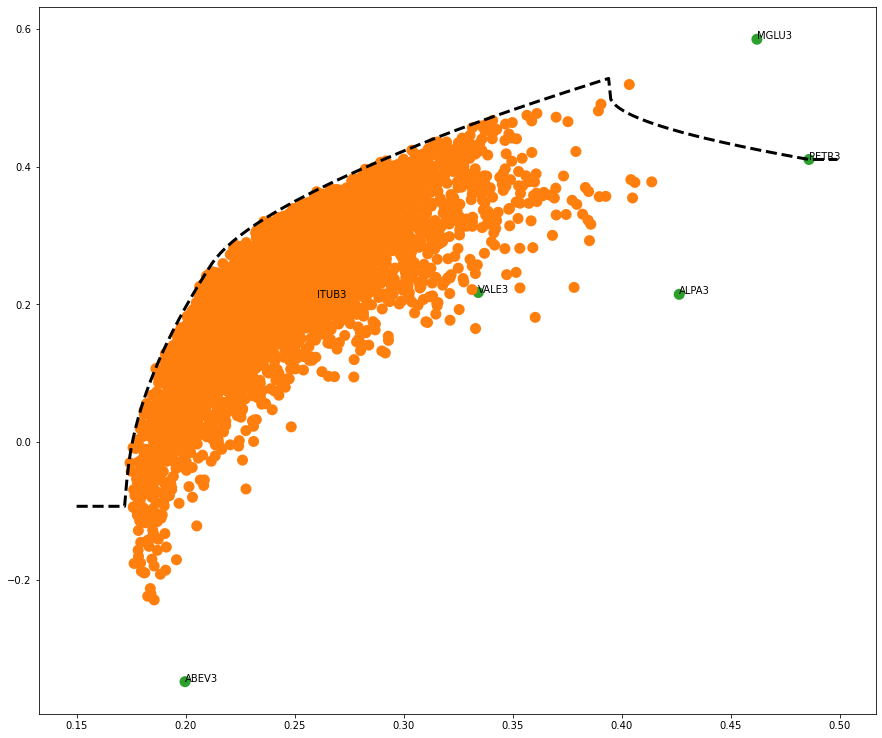

In [21]:
# Gráfico 
plt.figure(figsize=[15,13])

#Fronteira eficiente
plt.plot(risco_range, retorno_sim , 'k--', linewidth=3, )

#Carteiras simuladas
cores = {'ativo':'tab:green', 'carteira':'tab:orange'}
plt.scatter(x=rr_carteiras['risco'], y=rr_carteiras['retorno'], c=rr_carteiras['tipo'].map(cores), linewidths=5)
for i in range(6):
    plt.annotate(rr_carteiras.index[i],(rr_carteiras['risco'][i], rr_carteiras['retorno'][i]))

**Não existe solução para riscos menores que 17%. Na outra ponta da fronteira eficiente houve algum tipo de ótimo local e a fronteira ficou abaixo do ativo MGLU3. Nessa ponta o cálculo da fronteira está errado, visto que para o caso de escolher o mesmo risco que o ativo MGLU3 possui, a otimização deveria calcular uma carteira no mínimo com o mesmo retorno da MGLU3.**

O grupo tentou alterar algumas opções do otimizador, porém não houve resultado expressivo na fronteira eficiente. Talvez para encontrar o ótimo global nessas regiões onde a fronteira está estranha, seja necessário maior conhecimento de otimização.